In [1]:
# Prerequisites
import numpy as np
from numpy import log
from numpy import random as rd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import image
from tifffile import imwrite, imread
import configparser
from scipy.spatial.transform import Rotation

# Our classes
from BooleanModel import CBooleanModel, Render3DImage
from DirectionalDistributions import CRotationGenerator
from Particles import CParticle

# Introduction
There exist a variety of different models that can be used to generate synthetic data. On a basic level we distinguish between deterministic and random models. Deterministic models may seem appealing at first due to their simplistic nature and lack of randomness. However, real structures usually exhibit microscopic heterogeneity that cannot be captured by deterministic models.

One the most commonly encountered classes of random models are called 'germ-grain' models. In line with their name, they can be decomposed into two separate processes. Initially, points/positions (germs) are sampled in space. For each sampled germ a corresponding body (grain) is sampled and attached to the germ. In the following, we want to test out this procedure on a simple example:
* Generate 100 random points in $[0,1]^2$
* Plot them with different colored and shaped markers

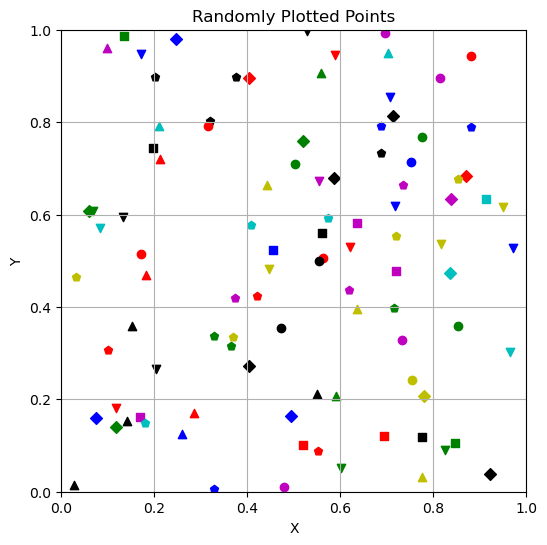

In [2]:
number_of_germs = 100

# Sampling of germ locations in 2D space
points = rd.random((number_of_germs,2))

color_options = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
marker_options = ['o', 's', '^', 'D', 'v', 'p']

colors = np.random.choice(color_options, number_of_germs)
markers = np.random.choice(marker_options, number_of_germs)

# Create the plot 
plt.figure(figsize=(6, 6))

for i in range(number_of_germs):
    plt.scatter(points[i, 0], points[i, 1], color=colors[i], marker=markers[i])

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Randomly Plotted Points')
plt.grid(True)
plt.show()

What we have just done is to have a very simple germ grain model. In this case, we used a germ process with randomly distributed points in space but a fixed number of germs. For the grain process, we sampled the color and shape independent from one another and attached it to the corresponding points.  

With such an initial example in mind, we can dive into further detail with the models used in our project. These are so-called '(stationary) Boolean models' which are germ-grain models which satisfy:
* the number of germs in an space $A\subset\mathbb{R}^d$ is a Poisson-distributed random variable with intensity $\lambda>0$.
* germ positions are sampled uniformly in space.
* grains are drawn independent of the germs.

A common misconception about uniformly distributed points in space is the assumption that they would spread out equally, much like a grid. However, this could not be further from reality as uniformly distributed points contain clusters and empty spaces alike. 

**Investigate on the behaviour of the constant $\lambda$. What does it control? Can you find out what quantity it is linked to? 
Hint: If looking at a single realization does not help, generating multiples may help you to find out.
Hint: The number of germs can be of interest.** 

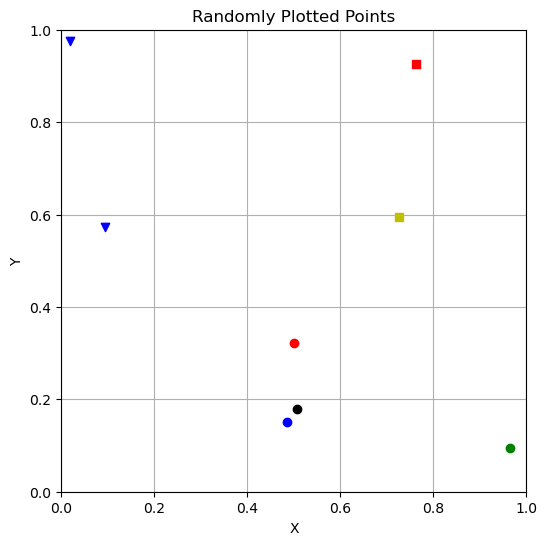

In [3]:
lmb = 10

number_of_germs = rd.poisson(lmb)

# Sampling of germ locations in 2D space
points = rd.random((number_of_germs,2))

color_options = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
marker_options = ['o', 's', '^', 'D', 'v', 'p']

colors = np.random.choice(color_options, number_of_germs)
markers = np.random.choice(marker_options, number_of_germs)

# Create the plot 
plt.figure(figsize=(6, 6))

for i in range(number_of_germs):
    plt.scatter(points[i, 0], points[i, 1], color=colors[i], marker=markers[i])

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Randomly Plotted Points')
plt.grid(True)
plt.show()

Result: $\lambda$ is the expected number of germs per unit volume. The number of germs in a volume $V$ is expected to be $\lambda*V$. However, the variance of the Poisson distribution is also $\lambda$ such that large deviations from the expected value may be observable.

*Further details: Boolean models are quite a big restriction towards germ-grain models. However, they offer knowledge on the expected value of geometrical quantities such as the volume, surface area, mean curvature and mean width. This information can be of use when analyzing the structures and its properties, e.g., for flow of water through the geometry. None the less, if we want to extend towards more general germ-grain processes, we can modify the underlying germ-process to consider interactions between sampled germs such that clustering or repulsion can be achieved. Common examples for this are Strauss or hard-core processes.*

# Synthetic Data of Geometrical Structures
In our case, we are interested in material structures such as foames or particle systems. These can usually be modelled and approximated using Boolean models. Below you can find a small range of examples that can be generated by using Boolean models. If foam-like structures are desired, taking the inverse of these realizations may already produce sufficient geometries.

*If you are interested, use Fiji (ImageJ) to look into the images (Supplementary Materials) in more detail. You can scroll through the slices, or use the 3D image viewer (Plugins -> 3D Viewer) where you rotate using the middle mouse button.*
<table><tr>
<td><img src="Notebook-Images/Sphere_Vv06_r15-30_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Cylinder_Vv06_r10-20_h80-160_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Cylinder_Vv06_r10-20_h80-160_Uniform-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Cylinder_Vv06_r10-20_h80-160_vMF20-Crop.png" style="width: 200px;"/></td>
</tr></table>
<table><tr>
<td><img src="Notebook-Images/Sphere_Vv06_r20-40_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Ellipsoid_Vv06_r10-20-10-20-40-80_Same-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Ellipsoid_Vv06_r10-20-10-20-40-80_Uniform-Crop.png" style="width: 200px;"/></td>
<td><img src="Notebook-Images/Ellipsoid_Vv06_r10-20-10-20-40-80_vMF20-Crop.png" style="width: 200px;"/></td>
</tr></table>

Before we go into more detail about options to create different datasets, we want to ask the question:
**Why are Boolean models useful to us?**
* Real structures are typically inhomogenous with variations in density, surface texture and structural appearance. However, at a small scale the areas of interest are homogenous*.
* They have been well studied in research and offer useful formulas for quantities such as the **expected** surface area, mean curvature, mean width, Euler number and more [Minkowski tensors & functionals]. These quantities are useful for analyzing and comparing structures.
* They are easy to understand and computationally cheap to generate.

*homogenous refers to the mathematical property, that the general appearance does not depend on the placement of our observation frame. 

Now that we know, why Boolean models suffice for generating random geometric structures, we can move our attention towards the options that we have at hand. 

## Particles
One of the most fundamental structural differences is produced by choosing from a small set of different particle types. The class ``CBooleanModel`` currently supports the shapes ``'Sphere'``,``'Cube'``,``'Cylinder'``,``'Ellipsoid'`` and ``'Cuboid'`` for the variable ``particle_shape``.

With a selected shape, we need to specify the exact dimensions of the particles we want to generate. The first option to select is a distribution for the size parameters of the shapes. This option ``particle_distribution`` can be set to ``'Constant'`` or ``'Uniform'`` and describes if particles should be the same or if sizes may be sampled uniformly from a specified interval $[r_\min,r_\max]$. For a general purpose, we specify the size parameters as a 3x2 ``np.array``. Each row corresponds to the upper and lower bounds of an interval. In case of a constant distribution of particle size, the second column will be ignored. Depending on the particle shape, a different amount of parameters is required:
* For ``'Sphere'`` the first row describes the radius.
* For ``'Cube'`` the first row describes the side-length.
* For ``'Cylinder'`` the first row describes the radius. The second row encodes the height. 
* For ``'Ellipsoid'`` the rows describe the length of the semi-axes, i.e., half-length of the main axes, in x-,y- and z-direction.
* For ``'Cuboid'`` the rows describe the side-lengths in x-,y- and z-direction.

**Try it out yourself. What can you observe when you use small and large sizes? What does this tell you?** 

*Further details: We are using vtk to render the image in 3D. You can rotate the structure around by holding down left-click on your mouse. Don't forget to close the window when you want to proceed.*

In [4]:
# Adjust these 
particle_shape = 'Cube' # 'Sphere','Cube','Cylinder','Ellipsoid','Cuboid'
particle_distribution = 'Constant' # 'Constant','Uniform'
particle_parameters = np.array([[50,0],
                                [0,0],
                                [0,0]])

# Setting up the Boolean Model Class - do not change
Model = CBooleanModel(volume_density=0.3,
                      image_size=np.array([256,256,256]),
                      particle_shape=particle_shape,
                      particle_parameters=particle_parameters,
                      particle_distribution=particle_distribution,
                      orientation = 'Uniform',
                      edge_treatment='Plus Sampling')

# Generating a random geometry
Model.generate()
# Rendering the geometry to a binary image
Model.render()
# Viewing the image
Render3DImage(Model.Image)

Generation complete. 116 objects have been created.
Rendering complete. The image can be accessed with 'self.Image'.


Result: With shrinking particle size, the number of generated objects and computation time increases drastically. However, most time is spend rendering the structures into an image. Therefore, rendering appears to be the computationally expensive part.

## Volume Density
Another option which strongly regulates the appearance and properties of structures is the volume density $V_V$. It is the fraction of space that is filled by the geometry, i.e., $V_V=0.6$ implies that 60\% of the space is occupied by the geometry while the rest of it is empty. If you recall, we have introduced Boolean models with an intensity $\lambda$ which was the expected number of germs. The volume density and intensity for a Boolean model are linked together by 

$$ V_V = 1 - \exp(-\lambda\bar{V}),$$

where $\bar{V}$ is the expected volume of a particle. Therefore, once we have all the information for particles (grain process), we have a one-to-one correspondence of $\lambda$ and $V_V$. We would argue that $V_V$ is a reasonable parameter to use as it strongly affects appearance and properties. Furthermore, it is easily understandable and comparable between models. 

**Play around with $V_V$ and observe the effect on the structure. Verify if $V_V$ is indeed the volume density of your realizations.**

In [5]:
Vv = 0.3

# Setting up the Boolean Model Class - do not change
Model = CBooleanModel(volume_density=Vv,
                      image_size=np.array([256,256,256]),
                      particle_shape='Sphere',
                      particle_parameters=np.array([[20,30],[0,0],[0,0]]),
                      particle_distribution='Uniform',
                      orientation = 'Uniform',
                      edge_treatment='Plus Sampling')
# Generating a random geometry
Model.generate()
# Rendering the geometry to a binary image
Model.render()
# Viewing the image
Render3DImage(Model.Image)

Generation complete. 144 objects have been created.
Rendering complete. The image can be accessed with 'self.Image'.


In [6]:
# Your Code for verifying if Vv is the actual volume density of the realizations
img = Model.Image






Result: $V_V$ and the volume density of realizations do not coincide. While they are close together, $V_V$ is just the expected volume density of the model. Each realization deviates from this value by chance. 

## Orientation
In previous calls of the ``CBooleanModel`` class you may have noticed the parameter ``orientation``. It describes the distribution used for sampling rotations to intrinsically rotate particles once placed in space. Supported values are ``'Fixed'``, ``'von Mises-Fisher'``, ``'Schladitz'`` and ``'Uniform'``, each corresponding to a respective distribution to draw from. 
* ``'Fixed'`` asserts a constant rotation that is applied to all particles, i.e., all particles point in the same direction.
* ``'von Mises-Fisher'`` uses an unimodal distribution, i.e., a distribution with a single preferred direction. Depending on a concentration parameter $\kappa$, sampled directions deviate from this prefferential axis. The corresponding grain is aligned with the sampled direction and afterwards intrinsically rotated with a uniformly drawn angle around that axis.
* ``'Schladitz'`` is a special case of an angular central Gaussian distribution. It can be used to sample directions in a girdle around the unit sphere, i.e., directions lie preferably in a plane. It depends on a parameter $\beta$ which we will not go into furhter detail here. Particles are again aligned with the sampled directions and intrinsically rotated with a uniformly drawn angle around that axis.
* ``'Uniform'`` samples and applies a uniformly distributed rotation from the group of rotations $SO(3)$.

*Comment: Particles assert the z-axis to be an axis of reference, e.g., a cylinder without rotation is drawn with its height along the z-axis. For Schladitz and von Mises-Fisher the z-axis first gets rotated on the sampled direction and then rotated intrinsically around this axis.*

**Become acustomed to the four different settings. For the options 'Schladitz' and 'von Mises-Fisher' try out different parameter settings and explain what they do.**

*You may alter volume density, particle type and size if it helps your understanding.*

In [7]:
orientation = 'Schladitz'
kappa_beta = 20


# Setting up the Boolean Model Class - do not change
Model = CBooleanModel(volume_density=0.05,
                      image_size=np.array([256,256,256]),
                      particle_shape='Cuboid',
                      particle_parameters=np.array([[10,10],[15,15],[50,50]]),
                      particle_distribution='Constant',
                      orientation = orientation,
                      orientation_parameters = np.array([0,0,kappa_beta]),
                      edge_treatment='Plus Sampling')
# Generating a random geometry
Model.generate()
# Rendering the geometry to a binary image
Model.render()
# Viewing the image
Render3DImage(Model.Image)

Generation complete. 195 objects have been created.
Rendering complete. The image can be accessed with 'self.Image'.


## Edge Treatment
This option is rather boring compared to the rest as it does not affect the overall appearance of structures generated by the Boolean models. The two options here are ``'Plus Sampling'`` and ``'Periodic'`` which refer to the way we work with the edge of our volume. An error that commonly appears in science, specifically with random models, is that researchers forget about the effect of observing something in a restricted window. This can lead to biases and errors when analyzing the structure for its properties. In our case, we consider the realizations to be a cut-out of an infinitiely large block with the same structure, that is observed in the finite realization at hand.

One way to obtain a proper realization is to generate germs in a window that is larger than the image size. The larger window has to be chosen/calculated adequately such that particles can stick out into the image. This can mean a noticeable increase in space to sample when images are large. 

The second and more efficient approach considers the image borders to be periodic, i.e., a particles that sticks out of the image at one side continues at the opposite side. This approach does not increase the numerical complexity but is less 'realistic'. Furthermore, it can lead to miscommunications when exchanging images and geometrical configurations as particles are typically stored only once when intersecting with the image border. Hence, including the information of periodic boundary treatment is important.

**Test out the two options and verify difference between 'Periodic' and 'Plus Sampling'.**

In [8]:
edge_treatment = 'Periodic'

Model = CBooleanModel(volume_density=0.03,
                      image_size=np.array([256,256,256]),
                      particle_shape='Cuboid',
                      particle_parameters=np.array([[10,10],[15,15],[200,200]]),
                      particle_distribution='Constant',
                      orientation = 'Fixed',
                      edge_treatment=edge_treatment)
# Generating a random geometry
Model.generate()
# Rendering the geometry to a binary image
Model.render()
# Viewing the image
Render3DImage(Model.Image)

Generation complete. 20 objects have been created.
Rendering complete. The image can be accessed with 'self.Image'.


**Now that we have seen all available options for generating different structures, try to replicate the structures from the example in the beginning. Note down your settings. Tip: They share the same volume density.**

In [9]:
# Particles
particle_shape = 'Sphere' # 'Sphere','Cube','Cylinder','Ellipsoid','Cuboid'
particle_distribution = 'Uniform' # 'Constant','Uniform'
particle_parameters = np.array([[10,10],
                                [0,0],
                                [0,0]])
# Volume density
Vv = 0.6
# Orientation
orientation = 'Fixed'
kappa_beta = 20

# Setting up the Boolean Model Class - do not change
Model = CBooleanModel(volume_density=Vv,
                      image_size=np.array([256,256,256]),
                      particle_shape=particle_shape,
                      particle_parameters=particle_parameters,
                      particle_distribution=particle_distribution,
                      orientation = orientation,
                      orientation_parameters = np.array([0,0,kappa_beta]),
                      edge_treatment='Periodic')
# Generating a random geometry
Model.generate()
# Rendering the geometry to a binary image
Model.render()
# Viewing the image
Render3DImage(Model.Image)

Generation complete. 3610 objects have been created.
Rendering complete. The image can be accessed with 'self.Image'.
